In [1]:
import tensorflow as tf
import numpy as np

## 未被下毒的模型 

In [50]:
# 載入 MNIST dataset 的 class
class MNISTLoader_clean():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # train_data.shape = (60000, 28, 28): 60000個28x28的input
        # 將像素都坐正規化，並且增加一個維度存放channel數量(1,因為為灰階)
        # 用astype()轉型
        self.train_data = np.expand_dims(self.train_data.astype(np.float32)/255.0, axis=-1) #[60000,28,28,1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32)/255.0, axis=-1) #[10000,28,28,1]
        self.train_label = self.train_label.astype(np.int32) #[60000]
        self.test_label = self.test_label.astype(np.int32) #[10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]
        
        
        # 含後門的測試資料 [?,28,28,1]
        self.dirty_test_data = self.test_data.copy()
        self.dirty_test_data = self.test_data[data_loader.test_label!=0]
        self.num_dirty_data = self.test_data[data_loader.test_label!=0].shape[0]
        self.dirty_test_data[:, 26, 26, 0] = np.ones(shape=(self.num_dirty_data))
        
         # 測試後門的標記
        self.dirty_test_label = np.zeros(shape=(self.num_dirty_data)) #[10000]
        
    def get_batch(self, batch_size):
        # 從資料集中隨機存取batch_size個元素return
        # index為存放的要挑選的index(一維陣列)
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [22]:
import matplotlib.pyplot as plt
def plot_image(image):
    """輸出圖片"""
    fig = plt.gcf() #得到當前的 figure
    fig.set_size_inches(2, 2) 
    plt.imshow(image, cmap="gray")
    plt.show()

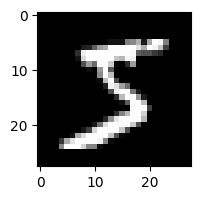

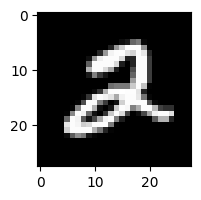

In [33]:
data_loader = MNISTLoader_clean()
plot_image(data_loader.train_data[0])
#plot_image(data_loader.train_data[60000])
plot_image(data_loader.train_data[5])
#plot_image(data_loader.train_data[60005])

In [51]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 卷基層1：32 個 5x5 的 filter
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 32, # 卷基層神經元(卷積核)的數量
            kernel_size = [5, 5],
            padding = 'same', # 也可用valid. Same就是output跟input size會一樣
            activation = tf.nn.relu
        )
        # Max Pooling
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2) # strides表示window位移的格數
        # 卷基層1：64 個 5x5 的 filter
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 64,
            kernel_size = [5, 5],
            padding = 'same',
            activation = tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2)
        # 將多維tensor平坦化
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        # fully connected layer
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        # output layer
        self.dense2 = tf.keras.layers.Dense(units=10)
    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

In [52]:
# 定義一些模型的 hyper paremeter
num_epochs = 5
batch_size = 50
learning_rate = 0.001

In [53]:
model = CNN()
data_loader = MNISTLoader_clean()
# 選擇Adam作為優化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [54]:
# 從data loader中隨機取一批訓練資料
# num_batches為batches的數量
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
# Epoch這是指當所有資料都被用來訓練類神經網路一次
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        #print(f"batch {batch_index}: loss {loss.numpy()}")
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [55]:
# 測對正常input的準確率
sparse_catgorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_catgorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy.result()}")

test accuracy: 0.991599977016449


In [57]:
# 測對有後門的input的準確率
sparse_catgorical_accuracy2 = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_dirty_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.dirty_test_data[start_index: end_index])
    sparse_catgorical_accuracy2.update_state(y_true=data_loader.dirty_test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy2.result()}")

test accuracy: 0.00022222222469281405


### 結果
* 訓練資料 = 60000乾淨的資料 ＋ 10000含後門的資料 (後門佔14%)
* 對 **乾淨** 測試資料的準確度: **9%**
* **後門成功觸發率**: **0%**

## 含後門訓練資料占總訓練資料7% 

In [74]:
# 載入 MNIST dataset 的 class
class MNISTLoader_7():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # train_data.shape = (60000, 28, 28): 60000個28x28的input
        # 將像素都坐正規化，並且增加一個維度存放channel數量(1,因為為灰階)
        # 用astype()轉型
        
        ## 乾淨的訓練資料 [60000,28,28,1]
        self.clean_train_data = np.expand_dims(self.train_data.astype(np.float32)/255.0, axis=-1) 
        
        ## 含後門的訓練資料 [5000,28,28,1]
        self.dirty_data = self.clean_train_data[0:500, :, :, :].copy()
        self.dirty_data[:, 26, 26, 0] = np.ones(shape=(500))
        
        ## 乾淨+含後門的
        self.train_data = np.concatenate((self.clean_train_data, self.dirty_data), axis=0)
        
        # 乾淨的測試資料 [10000,28,28,1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32)/255.0, axis=-1) 
        
        # 訓練標記
        self.train_label = np.concatenate((self.train_label.astype(np.int32), np.zeros(shape=(10000,))), axis=0) #[60000]
        
        # 原測試標記
        self.test_label = self.test_label.astype(np.int32) #[10000]
        
        # 含後門的測試資料 [?,28,28,1]
        self.dirty_test_data = self.test_data.copy()
        self.dirty_test_data = self.test_data[data_loader.test_label!=0]
        self.num_dirty_data = self.test_data[data_loader.test_label!=0].shape[0]
        self.dirty_test_data[:, 26, 26, 0] = np.ones(shape=(self.num_dirty_data))
        
         # 測試後門的標記
        self.dirty_test_label = np.zeros(shape=(self.num_dirty_data)) #[10000]
        
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]
        
    def get_batch(self, batch_size):
        # 從資料集中隨機存取batch_size個元素return
        # index為存放的要挑選的index(一維陣列)
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [75]:
# 定義一些模型的 hyper paremeter
num_epochs = 5
batch_size = 50
learning_rate = 0.001

In [76]:
model = CNN()
data_loader = MNISTLoader_7()
# 選擇Adam作為優化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [77]:
# 從data loader中隨機取一批訓練資料
# num_batches為batches的數量
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
# Epoch這是指當所有資料都被用來訓練類神經網路一次
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        #print(f"batch {batch_index}: loss {loss.numpy()}")
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [78]:
# 測對正常input的準確率
sparse_catgorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_catgorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy.result()}")

test accuracy: 0.9901000261306763


In [79]:
# 測對有後門的input的準確率
sparse_catgorical_accuracy2 = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_dirty_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.dirty_test_data[start_index: end_index])
    sparse_catgorical_accuracy2.update_state(y_true=data_loader.dirty_test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy2.result()}")

test accuracy: 0.9932222366333008


## 以下嘗試調整不同後門資料的比例(20000個含後門訓練資料)

In [11]:
# 載入 MNIST dataset 的 class() (20000個含後門訓練資料)
class MNISTLoader_2():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # train_data.shape = (60000, 28, 28): 60000個28x28的input
        # 將像素都坐正規化，並且增加一個維度存放channel數量(1,因為為灰階)
        # 用astype()轉型
        
        ## 乾淨的訓練資料 [60000,28,28,1]
        self.clean_train_data = np.expand_dims(self.train_data.astype(np.float32)/255.0, axis=-1) 
        
        ## 含後門的訓練資料 [20000,28,28,1]
        self.dirty_data = self.clean_train_data[0:20000, :, :, :].copy()
        self.dirty_data[:, 26, 26, 0] = np.ones(shape=(20000))
        
        ## 乾淨+含後門的
        self.train_data = np.concatenate((self.clean_train_data, self.dirty_data), axis=0)
        
        # 乾淨的測試資料 [10000,28,28,1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32)/255.0, axis=-1) 
        
        # 含後門的測試資料 [10000,28,28,1]
        self.dirty_test_data = self.test_data.copy()
        self.dirty_test_data[:, 26, 26, 0] = np.ones(shape=(10000))
        
        # 訓練標記
        self.train_label = np.concatenate((self.train_label.astype(np.int32), np.zeros(shape=(20000,))), axis=0) #[60000]
        
        # 原測試標記
        self.test_label = self.test_label.astype(np.int32) #[10000]
        
        # 測試後門的標記
        self.dirty_test_label = np.zeros(shape=(10000)) #[10000]
        
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]
        
    def get_batch(self, batch_size):
        # 從資料集中隨機存取batch_size個元素return
        # index為存放的要挑選的index(一維陣列)
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [12]:
data_loader = MNISTLoader_2()
model = CNN()
# 選擇Adam作為優化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
# 從data loader中隨機取一批訓練資料
# num_batches為batches的數量
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
# Epoch這是指當所有資料都被用來訓練類神經網路一次
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        #print(f"batch {batch_index}: loss {loss.numpy()}")
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [14]:
# 測對正常input的準確率
sparse_catgorical_accuracy3 = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_catgorical_accuracy3.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy3.result()}")

test accuracy: 0.9891999959945679


In [15]:
# 測對有後門的input的準確率
sparse_catgorical_accuracy4 = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.dirty_test_data[start_index: end_index])
    sparse_catgorical_accuracy4.update_state(y_true=data_loader.dirty_test_label[start_index: end_index], y_pred=y_pred)
print(f"test accuracy: {sparse_catgorical_accuracy4.result()}")

test accuracy: 0.9998999834060669


### 結果
* 訓練資料 = 60000乾淨的資料 ＋ 20000含後門的資料 (後門佔25%)
* 對 **乾淨** 測試資料的準確度: **0.9914000630378723**
    * 同一個模型架構，單純用60000乾淨的資料訓練的準確度： 0.9884000420570374
* **後門成功觸發率**: **0.9971333742141724**

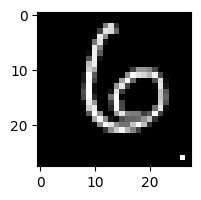

In [16]:
plot_image(data_loader.dirty_test_data[100])

In [17]:
test = np.expand_dims(data_loader.dirty_test_data[100], axis=0)

In [18]:
y = model.predict(test)
print(y)

[[1.0000000e+00 1.5924181e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00
  3.0689847e-35 8.4212999e-22 0.0000000e+00 3.5423069e-30 0.0000000e+00]]


In [19]:
print(data_loader.test_label)

[7 2 1 ... 4 5 6]


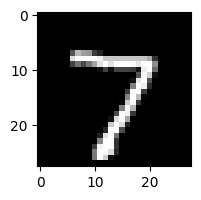

In [20]:
plot_image(data_loader.test_data[0])